In [7]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# I want to read in some of my training data and plot it to see what kind of distribution I am working with.

reddit_train_data = pd.read_csv("reddit_csv_file.csv")
reddit_train_data

,text,date,frustration,political,speaks of a solution,spreads news,fear or panic,blame,humorous,sarcastic,grateful,seeking help or answer
0,This is on us. One of us should have remembere...,1/25/25,1,0,0,0,0,0,0,1,0,0
1,"It’s that easy, huh?",1/25/25,0,0,0,0,0,0,0,1,0,0
2,"I have to say--the city, the office of emergen...",1/13/25,0,0,0,0,0,0,0,0,1,0
3,"The Kardashians reside in Calabasas, Californi...",1/13/25,0,1,0,0,0,0,0,0,0,0
4,"I was evacuated, applied Sunday and got approv...",1/14/25,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
521,this is the most reasonable thing I've read on...,01-09-2025,0,0,0,0,0,0,0,0,0,0
522,Polyester lining.,01-09-2025,0,0,0,0,0,0,0,0,0,0
523,I don’t disagree with the spirit of the “LAFD ...,01-09-2025,0,0,0,1,0,0,0,0,0,0
524,Well yes. Then again many if not all might say...,01-09-2025,0,0,0,0,0,1,0,0,0,0


In [36]:
reddit_train_data.rename(columns={"spreads news": "informative or news-focused"}, inplace=True)
reddit_train_data.rename(columns={"seeking help or answer": "seeking help or advice"}, inplace=True)
reddit_train_data.rename(columns={"speaks of a solution": "solution-focused"}, inplace=True)
reddit_train_data.rename(columns={"frustration": "frustration"}, inplace=True)
reddit_train_data.rename(columns={"blame": "blaming"}, inplace=True)
reddit_train_data.rename(columns={"fear or panic": "fearful or panicked"}, inplace=True)
reddit_train_data = reddit_train_data.drop(columns=["sarcastic"])
reddit_train_data = reddit_train_data.drop(columns=["humorous"])


reddit_train_data

,text,date,frustration,political,solution-focused,informative or news-focused,fearful or panicked,blaming,grateful,seeking help or advice
0,This is on us. One of us should have remembere...,1/25/25,1,0,0,0,0,0,0,0
1,"It’s that easy, huh?",1/25/25,0,0,0,0,0,0,0,0
2,"I have to say--the city, the office of emergen...",1/13/25,0,0,0,0,0,0,1,0
3,"The Kardashians reside in Calabasas, Californi...",1/13/25,0,1,0,0,0,0,0,0
4,"I was evacuated, applied Sunday and got approv...",1/14/25,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
521,this is the most reasonable thing I've read on...,01-09-2025,0,0,0,0,0,0,0,0
522,Polyester lining.,01-09-2025,0,0,0,0,0,0,0,0
523,I don’t disagree with the spirit of the “LAFD ...,01-09-2025,0,0,0,1,0,0,0,0
524,Well yes. Then again many if not all might say...,01-09-2025,0,0,0,0,0,1,0,0


In [37]:
def count_dist(X):
    dist_dict = {}

    new_X = X.drop(columns=['text','date'])

    for column in new_X:
        if column not in dist_dict:
            dist_dict[column] = 0
            
        for row in new_X[column]:
            if row == 1:
                dist_dict[column] += 1

    return dist_dict

count_dist(reddit_train_data)

{'frustration': 87,
 'political': 61,
 'solution-focused': 100,
 'informative or news-focused': 191,
 'fearful or panicked': 2,
 'blaming': 53,
 'grateful': 43,
 'seeking help or advice': 38}

In [38]:
def label_text(X,label):
    text_list = []
    if label in X:
        count = 0
        for text in X['text']:
            if X[label][count] == 1:
                text_list.append(text)
            count += 1

    return text_list

label_text(reddit_train_data, "offers a solution or recommends advice")

[]

In [39]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Device set to use mps:0


In [40]:
text = ["I'll just go jump in a river then"]
labels = ["grateful", "political", "frustration", "humorous", "sarcasm"]

results = classifier(text,labels,multi_label=True)
print(results)

[{'sequence': "I'll just go jump in a river then", 'labels': ['frustration', 'sarcasm', 'humorous', 'grateful', 'political'], 'scores': [0.9451837539672852, 0.907536506652832, 0.7070383429527283, 0.11761090159416199, 0.030364546924829483]}]


In [41]:
def get_score(model, text):
    labels = [
    'solution-focused',
    'frustration',
    'political',
    'blaming',
    'grateful',
    'fearful or panicked',
    'seeking help or advice',
    'informative or news-focused'
    ]
    results = model(text, labels, multi_label=True)

    return results

def predict_scores(model,full_text,thresh=.85):
    full_results = []

    for text in full_text['text']:
        results = get_score(model, text)

        sequence = results['sequence']
        ranked_labels = results['labels']
        ranked_scores = results['scores']

        current_post_data = {
            "text": sequence,
            "frustration": 0,
            "political": 0,
            "solution-focused": 0,
            "informative or news-focused": 0,
            "blaming": 0,
            "grateful": 0,
            "seeking help or advice": 0,
            "fearful or panicked": 0
        }

        count = 0
        for i in range(len(ranked_labels)):
            if ranked_scores[i] > thresh:
                current_post_data[ranked_labels[i]] = 1

        full_results.append(current_post_data)

    pandas_results = pd.DataFrame(full_results)

    return pandas_results

In [42]:
def compare_scores(predicted_text, og_text, total_score=True):
    if total_score:
        true_labels = og_text.drop(columns=['text','date'])
        predicted_labels = predicted_text.drop(columns=['text'])

        true_prediction = 0
        false_prediction = 0
        for i in range(len(true_labels)):
            for j in range(len(true_labels.loc[i])):
                if (true_labels.iloc[i,j] == predicted_labels.iloc[i,j]):
                    true_prediction += 1
                else:
                    false_prediction += 1

        correct_perc = true_prediction/(true_prediction+false_prediction)
    
        return correct_perc

    else:
        true_labels = og_text.drop(columns=['text','date'])
        predicted_labels = predicted_text.drop(columns=['text'])

        true_pos = 0
        false_pos = 0
        true_neg = 0
        false_neg = 0
        for i in range(len(true_labels)):
            for j in range(len(true_labels.loc[i])):
                if (true_labels.iloc[i,j] == predicted_labels.iloc[i,j] == 1):
                    true_pos += 1
                elif (true_labels.iloc[i,j] == 1 and predicted_labels.iloc[i,j] == 0):
                    false_neg += 1
                elif (true_labels.iloc[i,j] == 0 and predicted_labels.iloc[i,j] == 1):
                    false_pos += 1
                elif (true_labels.iloc[i,j] == predicted_labels.iloc[i,j] == 0):
                    true_neg += 1
                    
        return true_pos, false_pos, true_neg, false_neg

def problematic_labels(predicted_text, og_text):
    true_labels = og_text.drop(columns=['text','date'])
    predicted_labels = predicted_text.drop(columns=['text'])

    labels = [
    'solution-focused',
    'frustration',
    'political',
    'blaming',
    'grateful',
    'fearful or panicked',
    'seeking help or advice',
    'informative or news-focused'
    ]
    bad_label_count = {
        # 1st index: false pos
        # 2nd index: false neg
        "frustration": [0,0],
        "political": [0,0],
        "blaming": [0,0],
        "solution-focused": [0,0],
        "grateful": [0,0],
        "seeking help or advice": [0,0],
        "informative or news-focused": [0,0],
        "fearful or panicked": [0,0]
    }
    for i in range(len(true_labels)):
        for j in range(len(true_labels.loc[i])):
            if (true_labels.iloc[i,j] == predicted_labels.iloc[i,j] == 1):
                pass
            elif (true_labels.iloc[i,j] == 1 and predicted_labels.iloc[i,j] == 0):
                # false_neg 
                bad_label_count[true_labels.loc[i].index[j]][1] += 1
            elif (true_labels.iloc[i,j] == 0 and predicted_labels.iloc[i,j] == 1):
                # false_pos 
                bad_label_count[true_labels.loc[i].index[j]][0] += 1
            elif (true_labels.iloc[i,j] == predicted_labels.iloc[i,j] == 0):
                pass
                    
    return bad_label_count

In [43]:
# predicted_data_80 = predict_scores(classifier, reddit_train_data, thresh=.80)

In [44]:
# predicted_data_85 = predict_scores(classifier, reddit_train_data, thresh=.85)

In [45]:
predicted_data_90 = predict_scores(classifier, reddit_train_data, thresh=.90)

In [46]:
# predicted_data_95 = predict_scores(classifier, reddit_train_data, thresh=.95)

In [47]:
# def see_label_text(predicted_text, label):
#     text_list = []
#     if label in predicted_text:
#         count = 0
#         for text in predicted_text['text']:
#             if predicted_text[label][count] == 1:
#                 text_list.append(text)
#             count += 1
#     return text_list

# see_label_text(predicted_data_95, 'offers solution')

In [48]:
# score_80 = compare_scores(predicted_data_80, reddit_train_data)
# score_85 = compare_scores(predicted_data_85, reddit_train_data)
score_90 = compare_scores(predicted_data_90, reddit_train_data)
# score_95 = compare_scores(predicted_data_95, reddit_train_data)

print("Prediction Accuracy Scores")
print("--------------------------")
# print("Predicton accuracy when threshold for assigning a label is .80: ", f'{score_80:.4f}')
# print("Predicton accuracy when threshold for assigning a label is .85: ", f'{score_85:.4f}')
# print("Predicton accuracy when threshold for assigning a label is .90: ", f'{score_90:.4f}')
print("Predicton accuracy when threshold for assigning a label is .90: ", f'{score_90:.4f}')

Prediction Accuracy Scores
--------------------------
Predicton accuracy when threshold for assigning a label is .90:  0.8047


In [49]:
# true_pos_80, false_pos_80, true_neg_80, false_neg_80 = compare_scores(predicted_data_80, reddit_train_data, total_score=False)
# true_pos_85, false_pos_85, true_neg_85, false_neg_85 = compare_scores(predicted_data_85, reddit_train_data, total_score=False)
true_pos_90, false_pos_90, true_neg_90, false_neg_90 = compare_scores(predicted_data_90, reddit_train_data, total_score=False)
# true_pos_95, false_pos_95, true_neg_95, false_neg_95 = compare_scores(predicted_data_95, reddit_train_data, total_score=False)

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# conf_matrix = np.array([[true_pos_80, false_pos_80], [false_neg_80, true_neg_80]])

# plt.figure(figsize=(6,5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Actual Pos", "Actual Neg"], yticklabels=["Pred Pos", "Pred Neg"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix Heatmap for Threshold of .80")
# plt.savefig("confusion_matrix_80.png", dpi=300, bbox_inches='tight')
# plt.show()

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# conf_matrix = np.array([[true_pos_85, false_pos_85], [false_neg_85, true_neg_85]])

# plt.figure(figsize=(6,5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Actual Pos", "Actual Neg"], yticklabels=["Pred Pos", "Pred Neg"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix Heatmap for Threshold of .85")
# plt.savefig("confusion_matrix_85.png", dpi=300, bbox_inches='tight')
# plt.show()

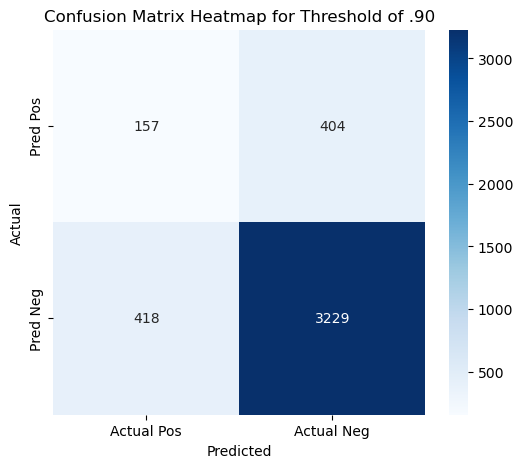

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conf_matrix = np.array([[true_pos_90, false_pos_90], [false_neg_90, true_neg_90]])

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Actual Pos", "Actual Neg"], yticklabels=["Pred Pos", "Pred Neg"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap for Threshold of .90")
plt.savefig("confusion_matrix_90.png", dpi=300, bbox_inches='tight')
plt.show()

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# conf_matrix = np.array([[true_pos_95, false_pos_95], [false_neg_95, true_neg_95]])

# plt.figure(figsize=(6,5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Actual Pos", "Actual Neg"], yticklabels=["Pred Pos", "Pred Neg"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix Heatmap for Threshold of .95")
# plt.savefig("confusion_matrix_95.png", dpi=300, bbox_inches='tight')
# plt.show()

In [58]:
# prob_labels_80 = problematic_labels(predicted_data_80, reddit_train_data)
# prob_labels_85 = problematic_labels(predicted_data_85, reddit_train_data)
# prob_labels_90 = problematic_labels(predicted_data_90, reddit_train_data)
prob_labels_90 = problematic_labels(predicted_data_90, reddit_train_data)
prob_labels_90

{'frustration': [44, 51],
 'political': [24, 35],
 'blaming': [40, 50],
 'solution-focused': [10, 92],
 'grateful': [61, 39],
 'seeking help or advice': [77, 33],
 'informative or news-focused': [58, 116],
 'fearful or panicked': [90, 2]}

In [59]:
# labels = list(prob_labels_80.keys())
# false_pos = [v[0] for v in prob_labels_80.values()]
# false_neg = [v[1] for v in prob_labels_80.values()]
# x = range(len(labels))

# width = 0.35
# plt.figure(figsize=(12, 6))
# plt.bar([i - width/2 for i in x], false_pos, width=width, label='False Positives')
# plt.bar([i + width/2 for i in x], false_neg, width=width, label='False Negatives')

# plt.xticks(x, labels, rotation=45, ha='right')
# plt.ylabel("Count")
# plt.title("False Positives and False Negatives per Label for Thresh=.80")
# plt.legend()
# plt.tight_layout()
# plt.savefig("false_pos_false_neg_80.png", dpi=300, bbox_inches='tight')
# plt.show()

In [60]:
# labels = list(prob_labels_85.keys())
# false_pos = [v[0] for v in prob_labels_85.values()]
# false_neg = [v[1] for v in prob_labels_85.values()]
# x = range(len(labels))

# width = 0.35
# plt.figure(figsize=(12, 6))
# plt.bar([i - width/2 for i in x], false_pos, width=width, label='False Positives')
# plt.bar([i + width/2 for i in x], false_neg, width=width, label='False Negatives')

# plt.xticks(x, labels, rotation=45, ha='right')
# plt.ylabel("Count")
# plt.title("False Positives and False Negatives per Label for Thresh=.85")
# plt.legend()
# plt.tight_layout()
# plt.savefig("false_pos_false_neg_85.png", dpi=300, bbox_inches='tight')
# plt.show()

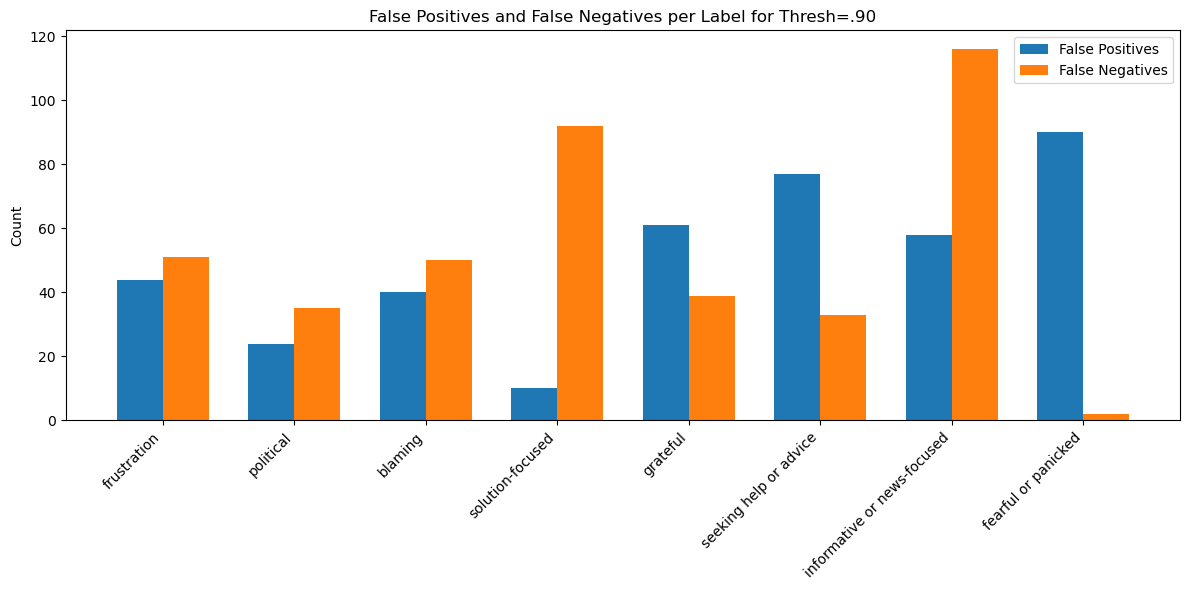

In [61]:
labels = list(prob_labels_90.keys())
false_pos = [v[0] for v in prob_labels_90.values()]
false_neg = [v[1] for v in prob_labels_90.values()]
x = range(len(labels))

width = 0.35
plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], false_pos, width=width, label='False Positives')
plt.bar([i + width/2 for i in x], false_neg, width=width, label='False Negatives')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Count")
plt.title("False Positives and False Negatives per Label for Thresh=.90")
plt.legend()
plt.tight_layout()
plt.savefig("false_pos_false_neg_90.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# labels = list(prob_labels_95.keys())
# false_pos = [v[0] for v in prob_labels_95.values()]
# false_neg = [v[1] for v in prob_labels_95.values()]
# x = range(len(labels))

# width = 0.35
# plt.figure(figsize=(12, 6))
# plt.bar([i - width/2 for i in x], false_pos, width=width, label='False Positives')
# plt.bar([i + width/2 for i in x], false_neg, width=width, label='False Negatives')

# plt.xticks(x, labels, rotation=45, ha='right')
# plt.ylabel("Count")
# plt.title("False Positives and False Negatives per Label for Thresh=.95")
# plt.legend()
# plt.tight_layout()
# plt.savefig("false_pos_false_neg_95.png", dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# ^ Above, it seems my model actually does a great job of zero-shot classification 
# I wanna try a real example of my reddit data to see how good it does 

example_text = reddit_train_data['text'][7]
labels = ["sarcasm", "grateful", "political", "frustration", "speaks of a solution", "blame", "humorous","spreads news", "fear or panic", "seeking help or answer"]

results = classifier(example_text,labels,multi_label=True)
for key in results:
    if key == 'labels':
        count = 0
        for value in results[key]:
            print(value)

In [34]:
for name, module in model.named_children():
    print(name, "->", module)

NameError: name 'model' is not defined

In [ ]:
# The following was generated from GPT. I did this because I figured it would have a good understanding of 
# how I should word things for descriptions. I wanted to confuse RoBERTa as little as possible. 

description_dict = {
    "frustration": "This text gives off a tone of frustration, irritation, or annoyance.",
    
    "political": "This text speaks of political involvement. This can include policy, names of politicians (both local and global), governence, political events, or political ideologies.",
    
    "speaks of a solution": "This text proposes a solution to a problem. It may include recommendations, advice, steps to fix an issue, or expressions of optimism about resolving a situation.",

    "spreads news": "This text shares information about an event, incident, or occurrence. It may reference breaking news, updates, reports, or developments, often with neutral or factual language.",

    "fear or panic": "This text expresses strong concern, urgency, or distress about a situation. It may include alarmist language, warnings, or a sense of impending danger.",

    "blame": "This text assigns responsibility or fault to a person, group, or entity. It may include accusations, criticism, or statements that hold someone accountable for an issue.",
    
    "humorous": "This text conveys amusement, jokes, or lightheartedness. It may include puns, wordplay, or exaggerated descriptions intended to entertain.",

    "sarcastic": "This text expresses mockery, irony, or insincerity. It may say the opposite of what is meant, often in a way that is exaggerated or critical.",

    "grateful": "This text expresses appreciation, thankfulness, or recognition of kindness. It may include words of gratitude for help, support, or positive experiences.",

    "seeking help": "This text asks for assistance, advice, or information. It may include direct questions, requests for guidance, or expressions of needing support."
}

In [ ]:
# for param in model.roberta.encoder.layer[:10].parameters():
#     param.requires_grad = False  # Freeze earlier layers